In [ ]:
# default_exp model

In [ ]:
# export
import importlib
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import argparse
from collections import OrderedDict
from adamp import AdamP
import wandb
import torch
import torchvision

from defocus.metrics import PSNR, SSIM

class GAN(pl.LightningModule):

    def __init__(self, hparams):
        super(GAN, self).__init__()
        
        self.hparams = hparams
        architecture = importlib.import_module('defocus.architecture.' + self.hparams.model_name)        
        self.G = architecture.Generator()
        self.D = architecture.Discriminator()
        
        data = importlib.import_module('defocus.data.' + self.hparams.model_name)        
        self.Dataset = data.Dataset
        
        self.adversarial_loss = self.set_weighted_loss(loss_functions=[getattr(nn, funcname)() for funcname in self.hparams.adv_loss[0::2]],
                                                  weights=[float(weight) for weight in self.hparams.adv_loss[1::2]],
                                                 )
        self.reconstruction_loss = self.set_weighted_loss(loss_functions=[getattr(nn, funcname)() for funcname in self.hparams.rec_loss[0::2]],
                                                  weights=[float(weight) for weight in self.hparams.rec_loss[1::2]],
                                                 )
        
        if self.hparams.per_loss is not None:
            # this is from DeblurGANv2
            # TODO: ESRGAN's perceptual loss version
            conv_3_3_layer = 14
            cnn = torchvision.models.vgg19(pretrained=True).features
            perceptual = nn.Sequential()
            perceptual = perceptual.eval()
            for i, layer in enumerate(list(cnn)):
                perceptual.add_module(str(i), layer)
                if i == conv_3_3_layer:
                    break
            self.P = perceptual
            self.perceptual_loss = self.set_weighted_loss(loss_functions=[getattr(nn, funcname)() for funcname in self.hparams.per_loss[0::2]],
                                                      weights=[float(weight) for weight in self.hparams.per_loss[1::2]],
                                                     )

        # cache for generated images
        self.generated_imgs = None
        self.last_imgs = None
        
        if self.hparams.flood_loss != 0:
            assert self.hparams.stop_loss is not None, "Can't do flood loss with stop loss"
        
        
        self.reduced_loss_g_adversarial = 0
        self.reduced_loss_d = 0
        
        if 'SSIM' in self.hparams.val_metric:
            self.SSIM = SSIM()
        if 'PSNR' in self.hparams.val_metric:
            self.PSNR = PSNR()

    def set_weighted_loss(self, loss_functions=[nn.BCEWithLogitsLoss], weights=[1.0]):
        def weighted_loss(input_, target):
            total = 0
            for (func, weight) in zip(loss_functions, weights):
                total += func(input_, target)*weight
            return total
        return weighted_loss
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        betas = self.hparams.betas
        optimizer = self.hparams.optimizer
        
        if optimizer == 'AdamP':
            opt_g = AdamP(self.G.parameters(), lr=lr, betas=betas, weight_decay=0, nesterov=False)
            opt_d = AdamP(self.D.parameters(), lr=lr, betas=betas, weight_decay=0, nesterov=False)
        else:
            opt_g = torch.optim.Adam(self.G.parameters(), lr=lr, betas=betas, weight_decay=0)
            opt_d = torch.optim.Adam(self.D.parameters(), lr=lr, betas=betas, weight_decay=0)

        scheduler_d = torch.optim.lr_scheduler.MultiStepLR(opt_d, milestones=[500,750,900], gamma=0.5)
        scheduler_g = torch.optim.lr_scheduler.MultiStepLR(opt_g, milestones=[500,750,900], gamma=0.5)
        return [opt_d, opt_g], [scheduler_d, scheduler_g]    

    def train_dataloader(self):        
        train_dataset = self.Dataset(root_folder=self.hparams.root_folder, 
                                     image_pair_list=self.hparams.image_pair_list,
                                    )
        return DataLoader(train_dataset, batch_size=self.hparams.batch_size, num_workers=self.hparams.num_workers)
    
    def val_dataloader(self):        
        val_dataset = self.Dataset(root_folder=self.hparams.root_folder, 
                                   image_pair_list=self.hparams.val_image_pair_list,
                                   mode='validation',
                                  )
        return DataLoader(val_dataset, batch_size=1, num_workers=self.hparams.num_workers)

    def forward(self, input_):
        return self.G(input_)

    def training_step(self, batch, batch_idx, optimizer_idx):
        input_, target = batch
        self.last_imgs = input_
        
        output = self.G(input_)
        loss_g_rec = 0
        for scaled_output, scaled_target in zip(output, target):
            loss_g_rec += self.reconstruction_loss(scaled_output, scaled_target)
        high_res_output = output[-1]
        high_res_target = target[-1]

        # train discriminator
        if optimizer_idx == 0:
            d_fake = self.D(high_res_output.detach())
            d_real = self.D(high_res_target)
            
            label_fake = torch.zeros_like(d_fake)
            label_real = torch.ones_like(d_real)
            if self.on_gpu:
                label_fake = label_fake.cuda(high_res_output.device.index)
                label_real = label_real.cuda(high_res_output.device.index)
            
            loss_d = self.adversarial_loss(d_fake, label_fake) + self.adversarial_loss(d_real, label_real)
            if self.hparams.flood_loss != 0:
                loss_d = (loss_d-self.hparams.flood_loss).abs()+self.hparams.flood_loss
            # this is unnecessary but I will use it for flood loss (maybe) and coop-gan
            reduced_loss_d = loss_d.clone()
            torch.distributed.all_reduce_multigpu([reduced_loss_d], op=torch.distributed.ReduceOp.SUM)
            self.reduced_loss_d = reduced_loss_d.item() / self.hparams.num_gpu
          
            tqdm_dict = {'loss_d': loss_d.item()}
            losses_and_logs = OrderedDict({
                'loss': loss_d,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return losses_and_logs

        # train generator
        if optimizer_idx == 1:            
            d_fake_with_gradient = self.D(high_res_output)
            
            label_real = torch.ones_like(d_fake_with_gradient)
            if self.on_gpu:
                label_real = label_real.cuda(high_res_output.device.index)
                
            loss_g_adversarial = self.adversarial_loss(d_fake_with_gradient, label_real)
            if self.hparams.flood_loss != 0:
                loss_g_adversarial = (loss_g_adversarial-self.hparams.flood_loss).abs()+self.hparams.flood_loss
            loss_g = loss_g_adversarial + loss_g_rec
            
            # again, this is unnecessary but I will use it for flood loss (maybe) and coop-gan
            reduced_loss_g_adversarial = loss_g_adversarial.clone()
            torch.distributed.all_reduce_multigpu([reduced_loss_g_adversarial], op=torch.distributed.ReduceOp.SUM)
            self.reduced_loss_g_adversarial = reduced_loss_g_adversarial.item() / self.hparams.num_gpu             
            
            tqdm_dict = {'loss_g': loss_g.item(), 
                         'loss_g_adversarial': loss_g_adversarial.item()}
            losses_and_logs = OrderedDict({
                'loss': loss_g,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return losses_and_logs

    def validation_step(self, batch, batch_idx):
        input_, target = batch
        
        output = self.G(input_)
        
        loss_g_rec = 0
        for scaled_output, scaled_target in zip(output, target):
            loss_g_rec += self.reconstruction_loss(scaled_output, scaled_target)
        high_res_output = output[-1]
        high_res_target = target[-1]        
        self.val_images = [high_res_output, high_res_target]
        
        d_fake = self.D(high_res_output.detach())
        d_real = self.D(high_res_target)
        label_fake = torch.zeros_like(d_fake)
        label_real = torch.ones_like(d_real)
        if self.on_gpu:
            label_fake = label_fake.cuda(high_res_output.device.index)
            label_real = label_real.cuda(high_res_output.device.index)
        loss_d = self.adversarial_loss(d_fake, label_fake) + self.adversarial_loss(d_real, label_real)
        d_fake_with_gradient = self.D(high_res_output)
        label_real = torch.ones_like(d_fake_with_gradient)
        if self.on_gpu:
            label_real = label_real.cuda(high_res_output.device.index)
        loss_g_adversarial = self.adversarial_loss(d_fake_with_gradient, label_real)
        loss_g = loss_g_adversarial + loss_g_rec
        
        PSNR = self.PSNR(high_res_output, high_res_target)
        SSIM = self.SSIM(high_res_output, high_res_target)
        logs = {'val_loss_d': loss_d.item(),
                'val_loss_g_adversarial': loss_g_adversarial.item(),
                'val_loss_g': loss_g.item(),
                'PSNR': PSNR.item(),
                'SSIM': SSIM.item(),
            }
        return logs
    
    def validation_epoch_end(self, outputs):
        avg_loss_d = np.asarray([x['val_loss_d'] for x in outputs]).mean()
        avg_val_loss_g_adversarial = np.asarray([x['val_loss_g_adversarial'] for x in outputs]).mean()
        avg_val_loss_g = np.asarray([x['val_loss_g'] for x in outputs]).mean()
        avg_PSNR = np.asarray([x['PSNR'] for x in outputs]).mean()
        avg_SSIM = np.asarray([x['SSIM'] for x in outputs]).mean()
        logs = {'val_loss_d': avg_loss_d,
                'val_loss_g_adversarial': avg_val_loss_g_adversarial,
                'val_loss_g': avg_val_loss_g,
                'val_PSNR': avg_PSNR,
                'val_SSIM': avg_SSIM,
                }
        return {'val_loss': avg_val_loss_g, 'log': logs}


    def optimizer_step(self, current_epoch, batch_idx, optimizer, optimizer_idx, 
                       second_order_closure=None, on_tpu=False, using_native_amp=True, using_lbfgs=False):
        if self.hparams.stop_loss is not None and self.current_epoch > self.hparams.stop_loss:
            # while updating the discriminator...
            if optimizer_idx == 0:
                # if generator is losing too much
                if self.reduced_loss_g_adversarial > 2.0:
                    # don't update the discriminator
                    optimizer.zero_grad()
                else:
                    # but update the discrimininator if the generator is not losing too much
                    self.trainer.scaler.step(optimizer)
                    optimizer.zero_grad()
            # while updating the generator...
            if optimizer_idx == 1:
                # if the discriminator is losing too much
                if self.reduced_loss_d > 2.0:
                    # don't update the generator
                    optimizer.zero_grad()
                else:
                    # but update the generator if the discriminator is not losing too much 
                    self.trainer.scaler.step(optimizer)
                    optimizer.zero_grad()
        # default optimization
        else:
            if torch.distributed.is_initialized():
                self.trainer.scaler.step(optimizer)
                optimizer.zero_grad()
            else:
                optimizer.step()
                optimizer.zero_grad()
        
    def on_epoch_end(self):
        if self.logger is not None:
            output = self.val_images[0][0].detach().cpu().numpy().transpose(1,2,0)
            target = self.val_images[1][0].detach().cpu().numpy().transpose(1,2,0)
            self.logger.experiment.log({"validation images": [wandb.Image(output, caption="output"),
                                                              wandb.Image(target, caption="target")]})
        else:
            pass

In [ ]:
from nbdev.export import *
notebook2script()

Converted 01_model.ipynb.
Converted 02_architecture_common.ipynb.
Converted 03_architecture_MSResNet.ipynb.
Converted 04_dataset_common.ipynb.
Converted 05_dataset_MSResNet.ipynb.
Converted 06_trainer_MSResNet.ipynb.
Converted 07_metrics.ipynb.
Converted 08_architecture_DeblurGANv2.ipynb.
Converted 09_dataset_DeblurGANv2.ipynb.
Converted 99_diffaugment.ipynb.
Converted Tutorial_without_lightning.ipynb.
Converted model_without_lightning.ipynb.
Converted trials.ipynb.


In [ ]:
# from lennart
def maybe_allreduce_mean(tensor: torch.FloatTensor, distributed: bool) -> torch.FloatTensor:
    if distributed and torch.distributed.is_initialized():
        batch_size = tensor.shape[0]
        tensor_sum = tensor.clone().sum()
        num_el = torch.full([], fill_value=batch_size, device=tensor.device, dtype=torch.float32)
        torch.distributed.all_reduce_multigpu([tensor_sum], op=torch.distributed.ReduceOp.SUM)
        torch.distributed.all_reduce_multigpu([num_el], op=torch.distributed.ReduceOp.SUM)
        tensor_mean = tensor_sum / num_el
        return tensor_mean
    else:
        return torch.mean(tensor)
	
def ra_ls_gan_loss(x: torch.FloatTensor,
                   y: torch.FloatTensor,
                   distributed: bool = True):
    xy_diff = x - maybe_allreduce_mean(y, distributed=distributed).detach()
    yx_diff = y - maybe_allreduce_mean(x, distributed=distributed).detach()

    return ((xy_diff - 1) ** 2 + (yx_diff + 1) ** 2) / 2

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
loaded = torch.load('lightning_logs/checkpoints_bs_32_adamp/epoch=50.ckpt', map_location='cpu')

In [ ]:
gan_model.load_state_dict(loaded['state_dict'])

<All keys matched successfully>

In [ ]:
for input_, target in gan_model.train_dataloader():
    output = gan_model(input_)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


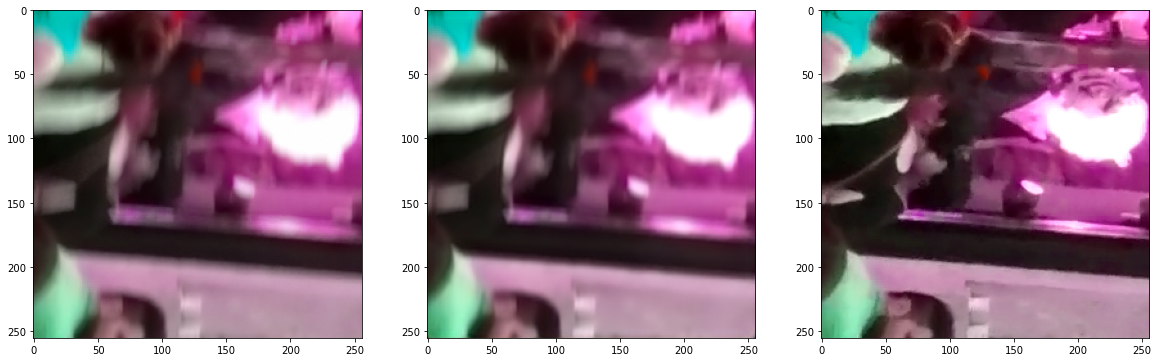

In [ ]:
batch_idx = 0
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow((input_[-1][batch_idx].detach().numpy().transpose(1,2,0))/255)
plt.subplot(132)
plt.imshow((output[-1][batch_idx].detach().numpy().transpose(1,2,0))/255)
plt.subplot(133)
plt.imshow((target[-1][batch_idx].detach().numpy().transpose(1,2,0))/255)

In [ ]:
from defocus.model import Model
import importlib
model_name = 'MSResNet'
architecture = importlib.import_module('defocus.architecture.' + model_name)

In [ ]:
loaded = torch.load('lightning_logs/checkpoints/epoch=50.ckpt', map_location='cpu')

In [ ]:
gan_model.load_state_dict(loaded['state_dict'])

<All keys matched successfully>

In [ ]:
model1_name = '14072020-singlegpu_bs_8_epoch_50.pth'
model2_name = '21202020-doublegpu_bs_8_Gbarrier/epoch_50.pth'
model = Model()
model.G = architecture.Generator()
model.D = architecture.Discriminator()
model.set_G_optimizer('Adam')
model.set_D_optimizer('Adam')
# model.load('19072020-doublegpu_bs_8/epoch_50.pth')
model.load(model1_name)
# model.load('epoch_75.pth')
# model.load('17072020-doublegpu_bs_16/epoch_60.pth')
model2 = Model()
model2.G = architecture.Generator()
model2.D = architecture.Discriminator()
model2.set_G_optimizer('AdamP')
model2.set_D_optimizer('AdamP')
# model2.load('19072020-doublegpu_bs_8/epoch_60.pth')
model2.load(model2_name)

In [ ]:
device = torch.device('cpu')
device2 = torch.device('cpu')

In [ ]:
model.to(device);
model2.to(device2);

In [ ]:
import random

In [ ]:
# seed=243948394
# seed=986896 # double better
# seed=675 # single better
seed = random.randint(0, 238782)
# seed=21237
print(seed)
random.seed(seed)
torch.manual_seed(seed)
for input_, target in gan_model.train_dataloader():
    break

73091


In [ ]:
with torch.no_grad():
    output = model.G(input_)
    print('model 1 done')
    output2 = model2.G(input_)
    print('model 2 done')
    output_lightning = gan_model(input_)
    print('model lightning done')

model 1 done
model 2 done
model lightning done


In [ ]:
batch_idx = random.randint(0,3)
inp = input_[-1][batch_idx].detach().cpu().numpy().transpose(1,2,0)
trg = target[-1][batch_idx].detach().cpu().numpy().transpose(1,2,0)
out1 = output[-1][batch_idx].detach().cpu().numpy().transpose(1,2,0)
out2 = output2[-1][batch_idx].detach().cpu().numpy().transpose(1,2,0)
out_lightning = output_lightning[-1][batch_idx].detach().cpu().numpy().transpose(1,2,0)
plt.figure(figsize=(20,20))

plt.subplot(331)
plt.title('input')
plt.imshow(inp/255)
plt.subplot(332)
plt.title('out_' + model1_name)
plt.imshow(out1/255)
plt.subplot(333)
plt.title('trg')
plt.imshow(trg/255)
plt.subplot(334)
plt.title('input')
plt.imshow(inp/255)
plt.subplot(335)
plt.title('out_' + model2_name)
plt.imshow(out2/255)
plt.subplot(336)
plt.title('trg')
plt.imshow(trg/255)
plt.subplot(337)
plt.title('input')
plt.imshow(inp/255)
plt.subplot(338)
plt.title('out_lightning')
plt.imshow(out_lightning/255)
plt.subplot(339)
plt.title('trg')
plt.imshow(trg/255)

plt.savefig('multigpu_compare/seed_{}.png'.format(seed))